In [4]:
!pip3 install -r requirements.txt

  Using cached matplotlib-3.10.7-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp311-cp311-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl (270 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.1 MB/s eta 0:00:00
Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl (65 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/6 [fonttools]  WARNING: The scripts fonttools, pyftmerge, pyftsubset and ttx are installed in '/Library/Frameworks/Python.framework/Versions/3.11/bin' which is not on PAT

In [5]:
import re
import pandas as pd
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier 
import sklearn
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator

In [6]:
PUNCTUATIONS = [',','-',';',':','.','!','?','(',')','[',']','{','}','/','"','\'','_']
WORDS = "word_stats"
PUNCs = "punctuations"
TFIDF = "tfidf"
EMBED = "embedding"


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
    
def repeated_words(text, bound=5):
    counts = Counter(text.split())
    return sum(1 for word, c in counts.items() if c > bound)

def rare_words(text, bound=5):
    counts = Counter(text.split())
    return sum(1 for word, c in counts.items() if c < bound)


In [7]:
df = pd.read_csv('train_v2_drcat_02.csv')
df.drop(columns=["prompt_name", "source", "RDizzl3_seven"], inplace=True)
majority = df["label"].value_counts().max() / len(df)
print("Majority baseline: ",majority)

Majority baseline:  0.6100338771507533


In [8]:
class Model:
    def __init__(self, df):
        self.df = df
        self.pipeline = None
        self.fitted = False
        self.numeric_cols = None

    def preprocess(self, df):
        df["text"] = df["text"].apply(clean_text)
        df["char_count"] = df["text"].str.len()
        df["word_count"] = df["text"].apply(lambda x: len(x.split()))
        df["high_repeat_words"] = df["text"].apply(repeated_words)
        df["uncommon_words"] = df["text"].apply(rare_words)

        # punctuation percentages
        for p in PUNCTUATIONS:
            df[f"punc_{p}"] = (
                df["text"].str.count(re.escape(p)) / df["char_count"]
            )

        df["total_punc"] = df[[f"punc_{p}" for p in PUNCTUATIONS]].sum(axis=1)

        return df

    def build_pipeline(self, features):
        transformers = []
        self.selected_features = features

        if WORDS in features:
            word_stats_cols = [
                "word_count",
                "high_repeat_words",
                "uncommon_words",
            ]
            transformers.append((WORDS, StandardScaler(with_mean=False), word_stats_cols))
        
        if PUNCs in features:
            punc_cols = [f"punc_{p}" for p in PUNCTUATIONS] + ["total_punc"]
            transformers.append((PUNCs, StandardScaler(with_mean=False), punc_cols))

        if TFIDF in features:
            transformers.append((TFIDF, TfidfVectorizer(max_features=10000, ngram_range=(1, 2)), "text"))

        preprocessor = ColumnTransformer(transformers, sparse_threshold=0.3)
        # classifier = LogisticRegression(solver="saga", penalty="l2", max_iter=300, n_jobs=-1)
        # classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=2000)
        #classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=500, random_state=42)

        classifier = LinearSVC()

        self.pipeline = Pipeline([
            ("preprocess", preprocessor),
            ("classifier", classifier)
        ])

    def train(self, features, random_state=42):
        df = self.preprocess(self.df)
        print("Building pipeline...")

        self.build_pipeline(features)

        X = df
        y = df["label"]

        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=0.1, stratify=y, random_state=random_state
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.111, stratify=y_train_val,
            random_state=random_state
        )

        print("Training model...")
        self.pipeline.fit(X_train, y_train)
        self.fitted = True

        # Validation evaluation
        print("\n--- Validation Evaluation ---")
        y_pred = self.pipeline.predict(X_val)
        print("Accuracy:", metrics.accuracy_score(y_val, y_pred))
        print("F1 Score:", metrics.f1_score(y_val, y_pred))
        print(metrics.classification_report(y_val, y_pred))
        cm = confusion_matrix(y_val, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix: Predicted vs True Labels')
        plt.show()

        # Test evaluation
        print("\n--- Test Evaluation ---")
        y_test_pred = self.pipeline.predict(X_test)
        print("Test Accuracy:", metrics.accuracy_score(y_test, y_test_pred))
        print("Test F1 Score:", metrics.f1_score(y_test, y_test_pred))
        print(metrics.classification_report(y_test, y_test_pred))
        cm = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix: Predicted vs True Labels')
        plt.show()
        print("Training complete.\n")

    def predict(self, df, label):
        if not self.fitted:
            raise ValueError("Model must be trained or loaded before predicting.")

        df = self.preprocess(df)
        result = self.pipeline.predict(df)

        print("\n--- Predict Evaluation ---")
        print("Test Accuracy:", metrics.accuracy_score(label, result))
        print("Test F1 Score:", metrics.f1_score(label, result))
        print(metrics.classification_report(label, result))  

        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(label, result)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix: Predicted vs True Labels')
        return result

    def save(self, path="model.pkl"):
        pickle.dump(self.pipeline, open(path, "wb"))

    def load(self, path="model.pkl"):
        self.pipeline = pickle.load(open(path, "rb"))
        self.fitted = True


Building pipeline...
Training model...

--- Validation Evaluation ---
Accuracy: 0.996877091233549
F1 Score: 0.9959839357429718
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2735
           1       1.00      0.99      1.00      1748

    accuracy                           1.00      4483
   macro avg       1.00      1.00      1.00      4483
weighted avg       1.00      1.00      1.00      4483



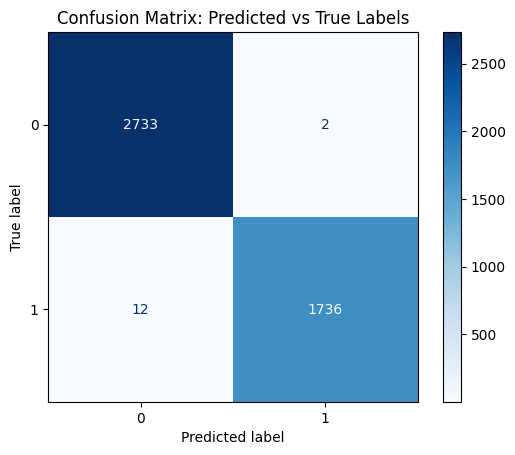


--- Test Evaluation ---
Test Accuracy: 0.9973256073100066
Test F1 Score: 0.9965616045845272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2737
           1       1.00      0.99      1.00      1750

    accuracy                           1.00      4487
   macro avg       1.00      1.00      1.00      4487
weighted avg       1.00      1.00      1.00      4487



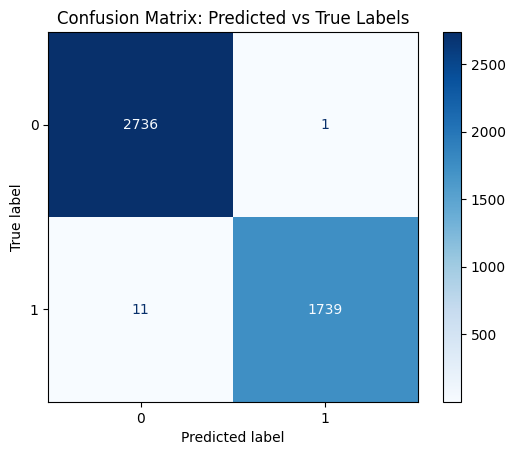

Training complete.

Building pipeline...
Training model...

--- Validation Evaluation ---
Accuracy: 0.82578630381441
F1 Score: 0.7722368037328667
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2735
           1       0.79      0.76      0.77      1748

    accuracy                           0.83      4483
   macro avg       0.82      0.81      0.82      4483
weighted avg       0.82      0.83      0.83      4483



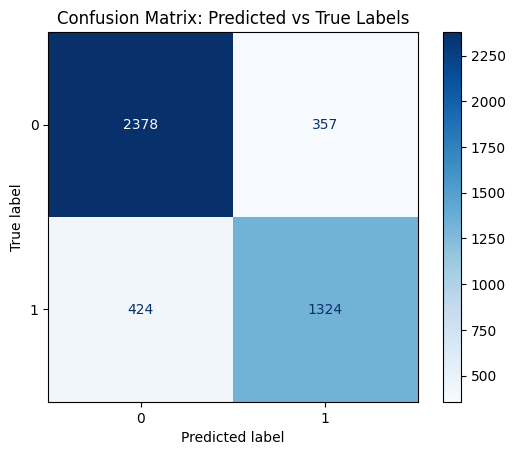


--- Test Evaluation ---
Test Accuracy: 0.8275016714954313
Test F1 Score: 0.772887323943662
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2737
           1       0.79      0.75      0.77      1750

    accuracy                           0.83      4487
   macro avg       0.82      0.81      0.82      4487
weighted avg       0.83      0.83      0.83      4487



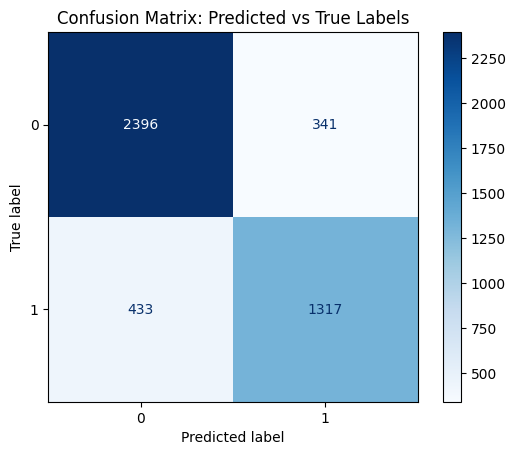

Training complete.

Building pipeline...
Training model...

--- Validation Evaluation ---
Accuracy: 0.5766227972339951
F1 Score: 0.2683114880493446
              precision    recall  f1-score   support

           0       0.62      0.82      0.70      2735
           1       0.41      0.20      0.27      1748

    accuracy                           0.58      4483
   macro avg       0.51      0.51      0.49      4483
weighted avg       0.54      0.58      0.53      4483



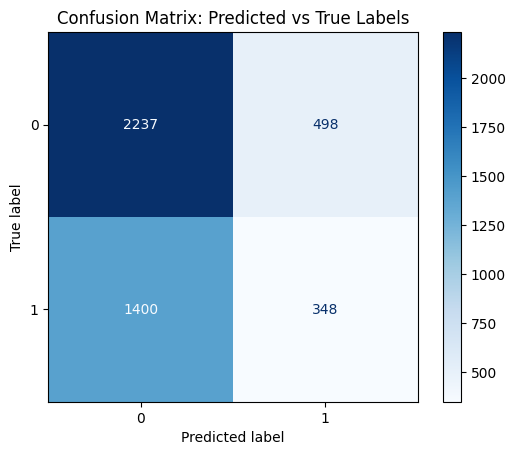


--- Test Evaluation ---
Test Accuracy: 0.5810118119010474
Test F1 Score: 0.27858787413660785
              precision    recall  f1-score   support

           0       0.62      0.82      0.70      2737
           1       0.42      0.21      0.28      1750

    accuracy                           0.58      4487
   macro avg       0.52      0.51      0.49      4487
weighted avg       0.54      0.58      0.54      4487



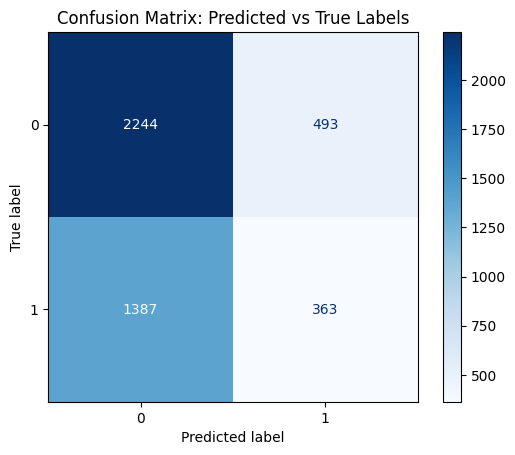

Training complete.

Building pipeline...
Training model...

--- Validation Evaluation ---
Accuracy: 0.9966540263216596
F1 Score: 0.9956983080011471
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2735
           1       1.00      0.99      1.00      1748

    accuracy                           1.00      4483
   macro avg       1.00      1.00      1.00      4483
weighted avg       1.00      1.00      1.00      4483



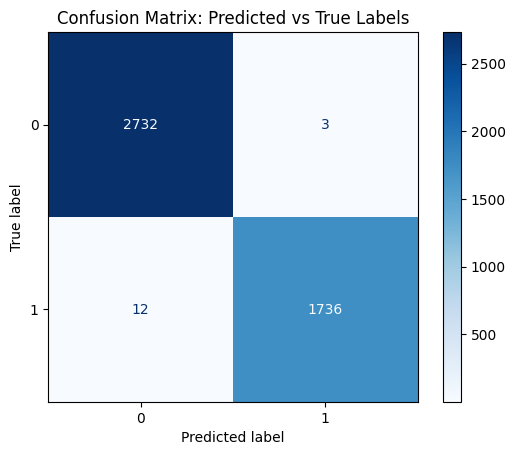


--- Test Evaluation ---
Test Accuracy: 0.9975484733675062
Test F1 Score: 0.996847234164517
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2737
           1       1.00      0.99      1.00      1750

    accuracy                           1.00      4487
   macro avg       1.00      1.00      1.00      4487
weighted avg       1.00      1.00      1.00      4487



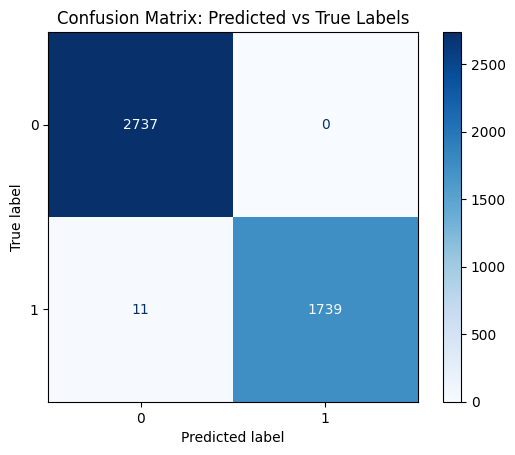

Training complete.



In [9]:
# initialize model
model = Model(df)
model.train([PUNCs, WORDS, TFIDF], 23)
model.train([PUNCs], 23)
model.train([WORDS], 23)
model.train([TFIDF], 23)


--- Predict Evaluation ---
Test Accuracy: 0.6181818181818182
Test F1 Score: 0.7640449438202247
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.72      0.81      0.76        42

    accuracy                           0.62        55
   macro avg       0.36      0.40      0.38        55
weighted avg       0.55      0.62      0.58        55


--- Confusion Matrix ---
Majority baseline: 0.7636363636363637


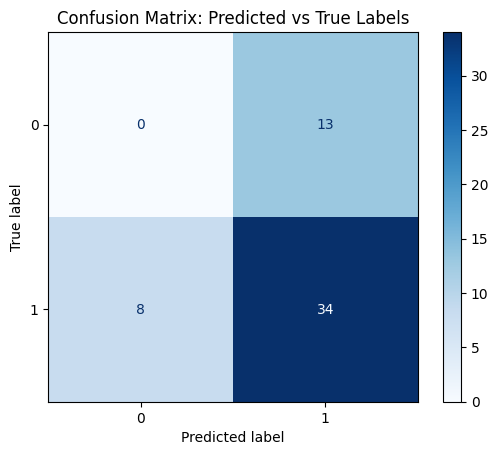

In [10]:
# testing with self generated ai essays and human essays i found online
df1 = pd.read_csv('gpt5-prompted-essays.csv')
df1.drop(columns=["model", "prompt"], inplace=True)
df2 = pd.read_csv('adt_essays.csv')

# labels 1 = AI, 0 Human
label_ai = pd.Series([1]*len(df1))
label_human = pd.Series([0]*len(df2))

df_combined = pd.concat([df1,df2], ignore_index=True)
labels_combined = pd.concat([label_ai,label_human], ignore_index=True)

results = model.predict(df_combined, labels_combined)

majority = labels_combined.value_counts().max() / len(labels_combined)
print("Majority baseline:", majority)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8b90cfd1-dc1a-4fe8-b34e-e094b9bf08cf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>